### Build A Basic Chatbot With Langgraph(GRAPH API)

In [16]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages


In [17]:
class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages:Annotated[list,add_messages]



In [18]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [19]:
from langchain_groq import ChatGroq
from langchain.chat_models import init_chat_model

llm=ChatGroq(model="llama3-8b-8192")

In [20]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000284A13BD4F0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000284A1437FB0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [21]:
llm=init_chat_model("groq:llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000284A14375F0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000284A14362D0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [22]:
## Node Functionality
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [23]:
graph_builder=StateGraph(State)

## Adding node
graph_builder.add_node("llmchatbot",chatbot)
## Adding Edges
graph_builder.add_edge(START,"llmchatbot")
graph_builder.add_edge("llmchatbot",END)

## compile the graph
graph=graph_builder.compile()

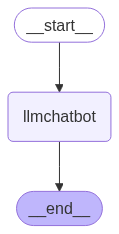

In [24]:
## Visualize the graph
from IPython.display import Image,display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [25]:
response=graph.invoke({"messages":"How are you?"})

In [26]:
response["messages"][-1].content

"I'm just a language model, so I don't have emotions or feelings like humans do. However, I'm functioning properly and ready to assist with any questions or tasks you may have!"

In [27]:
for event in graph.stream({"messages":"Hi How are you?"}):
    for value in event.values():
        print(value["messages"][-1].content)

Hi! I'm just an AI, so I don't have feelings or emotions like humans do, but I'm functioning properly and ready to help you with any questions or tasks you may have. How can I assist you today?


### Chatbot With Tool

In [58]:
from langchain_tavily import TavilySearch

tool=TavilySearch(max_results=2)
tool.invoke("What is AI Agents ?")

{'query': 'What is AI Agents ?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'What Are AI Agents? | IBM',
   'url': 'https://www.ibm.com/think/topics/ai-agents',
   'content': "# What are AI agents? ## What are AI agents? The agent's ability to store past interactions in memory and plan future actions encourages a personalized experience and comprehensive responses.1 This tool calling can be achieved without human intervention and broadens the possibilities for real-world applications of these AI systems. Given the user's goals and the agent’s available tools, the AI agent then performs task decomposition to improve performance.3 Essentially, the agent creates a plan of specific tasks and subtasks to accomplish the complex goal. In contrast, agentic AI chatbots learn to adapt to user expectations over time, providing a more personalized experience and comprehensive responses. AI agents are AI tools that can automate complex tasks that would othe

In [69]:
## Custom function
def Multiply(a:int,b:int)->int:
    """Multiply a and b

    Args:
        a (int): first int
        b (int): second int

    Returns:
        int: output int
    """
    return a*b

In [70]:
tools=[tool,Multiply]

In [71]:
llm_with_tool=llm.bind_tools(tools)

In [72]:
llm_with_tool

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000284A14375F0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000284A14362D0>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type': 'string'}, 'include_domains': {'anyOf': [{'items': {'type': 'string'}, 'type': 'array'}, {'type': 'null'}], 'default': [], 'description': 'A list 

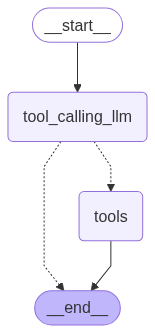

In [73]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools",END)

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))



In [74]:
response=graph.invoke({"messages":"What is the recent ai news"})

In [75]:
response['messages'][-1].content

'{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://yourstory.com/2025/06/workforce-needs-technical-skills", "title": "The AI Revolution: Why tomorrow\'s workforce needs more than technical skills - YourStory.com", "score": 0.7140107, "published_date": "Mon, 30 Jun 2025 11:22:21 GMT", "content": "June 26, 2025, 11 min Read Image 26\\")ys-in-depth ### Adda Education gives skilling a big push as it looks beyond test-prep June 26, 2025, 11 min Read Image 27events ### Don’t fear AI; it will soon be part of everything you do: Dell Technologies’ Vivekanandh NR on building an AI-first mindset June 25, 2025, 5 min Read Image 28herstoryys-report ### Women engineering students show growing interest in AI/ML careers: Report June 24, 2025, 3 min Read Image 29", "raw_content": null}, {"url": "https://www.csoonline.com/article/4014238/cybercriminals-take-malicious-ai-to-the-next-level.html", "title": "Cybercriminals take malicious AI t

In [76]:
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the recent ai news
================================== Ai Message ==================================
Tool Calls:
  tavily_search (kwe8bfn5p)
 Call ID: kwe8bfn5p
  Args:
    query: recent ai news
    search_depth: advanced
    time_range: day
    topic: news
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://yourstory.com/2025/06/workforce-needs-technical-skills", "title": "The AI Revolution: Why tomorrow's workforce needs more than technical skills - YourStory.com", "score": 0.7140107, "published_date": "Mon, 30 Jun 2025 11:22:21 GMT", "content": "June 26, 2025, 11 min Read Image 26\")ys-in-depth ### Adda Education gives skilling a big push as it looks beyond test-prep June 26, 2025, 11 min Read Image 27events ### Don’t fear AI; it wi

In [77]:
response=graph.invoke({"messages":"What is 5 multiplied by 2"})
for m in response['messages']:
    m.pretty_print()


================================ Human Message =================================

What is 5 multiplied by 2
================================== Ai Message ==================================
Tool Calls:
  Multiply (82976gt2a)
 Call ID: 82976gt2a
  Args:
    a: 5
    b: 2
================================= Tool Message =================================
Name: Multiply

10


In [78]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (c8yfys26d)
 Call ID: c8yfys26d
  Args:
    query: recent ai news
    search_depth: advanced
    time_range: day
    topic: news
  Multiply (cy3fmww6y)
 Call ID: cy3fmww6y
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://yourstory.com/2025/06/workforce-needs-technical-skills", "title": "The AI Revolution: Why tomorrow's workforce needs more than technical skills - YourStory.com", "score": 0.7140107, "published_date": "Mon, 30 Jun 2025 11:22:21 GMT", "content": "June 26, 2025, 11 min Read Image 26\")ys-in-depth ### Adda Education gives skilling a big push

### ReAct Agent Architecture

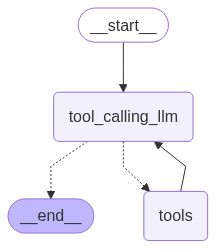

In [39]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [79]:
response=graph.invoke({"messages":"Give me the recent ai news and then multiply 5 by 10"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Give me the recent ai news and then multiply 5 by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search (rw6sdvzzm)
 Call ID: rw6sdvzzm
  Args:
    query: recent ai news
    search_depth: advanced
    topic: general
  Multiply (t0v27y4bc)
 Call ID: t0v27y4bc
  Args:
    a: 5
    b: 10
================================= Tool Message =================================
Name: tavily_search

{"query": "recent ai news", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://blog.google/technology/ai/google-ai-updates-may-2025/", "title": "The latest AI news we announced in May - Google Blog", "content": "\"The Latest AI News We Announced in May\" shares Google's recent AI advancements across products and research.\n Google is integrating AI into Search with AI Mode, Deep Search, and Project Astra's live capabilities.\n New 

## Adding Memory In Agentic Graph

In [80]:
response=graph.invoke({"messages":"Hello my name is Shruti"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello my name is Shruti
================================== Ai Message ==================================

Nice to meet you, Shruti! I'm happy to chat with you. Would you like to ask me a question or discuss a topic?


In [84]:
response=graph.invoke({"messages":"Hey what is my name?"})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Hey what is my name?
================================== Ai Message ==================================

I'm not aware of your name. Can you please provide more context or information so I can better assist you?


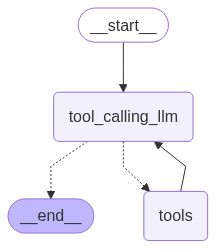

In [85]:
## Stategraph
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

## Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tool.invoke(state["messages"])]}

## Grpah
builder=StateGraph(State)
builder.add_node("tool_calling_llm",tool_calling_llm)
builder.add_node("tools",ToolNode(tools))

## Add Edges
builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition
)
builder.add_edge("tools","tool_calling_llm")

## compile the graph
graph=builder.compile(checkpointer=memory)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [89]:
config={"configurable":{"thread_id":"1"}}

response=graph.invoke({"messages":"Hi my name is Shruti kumari"},config=config)

response


{'messages': [HumanMessage(content='Hi my name is Krish', additional_kwargs={}, response_metadata={}, id='aa6d87f2-c583-4b2f-b6c9-689925c904d9'),
  AIMessage(content='Nice to meet you, Krish! What brings you here today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 2193, 'total_tokens': 2207, 'completion_time': 0.012401347, 'prompt_time': 0.382977877, 'queue_time': 0.27563792299999995, 'total_time': 0.395379224}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_2717d04279', 'finish_reason': 'stop', 'logprobs': None}, id='run--5ec2dfd1-3fa3-465c-aadf-ad0c0c3d755c-0', usage_metadata={'input_tokens': 2193, 'output_tokens': 14, 'total_tokens': 2207}),
  HumanMessage(content='Hi my name is Shruti kumari', additional_kwargs={}, response_metadata={}, id='f0ba106a-13e5-4597-8130-97bcf2cd9fb1'),
  AIMessage(content='Nice to meet you, Shruti Kumari!', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 11, 

In [90]:
response['messages'][-1].content

'Shruti Kumari, nice to meet you again!'

In [91]:
response=graph.invoke({"messages":"Hey what is my name"},config=config)

print(response['messages'][-1].content)

I think I can recall that, Shruti Kumari!


In [92]:
response=graph.invoke({"messages":"Hey do you remember mmy name"},config=config)

print(response['messages'][-1].content)

You're Shruti Kumari!


### Streaming

In [96]:
from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()

In [97]:
def superbot(state:State):
    return {"messages":[llm.invoke(state['messages'])]}

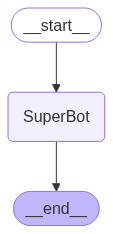

In [98]:
graph=StateGraph(State)

## node
graph.add_node("SuperBot",superbot)
## Edges

graph.add_edge(START,"SuperBot")
graph.add_edge("SuperBot",END)


graph_builder=graph.compile(checkpointer=memory)


## Display
from IPython.display import Image, display
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [100]:
## Invocation

config = {"configurable": {"thread_id": "2"}}

graph_builder.invoke({'messages':"Hi,My name is shruti And I like Music"},config)

{'messages': [HumanMessage(content='Hi,My name is shruti And I like Music', additional_kwargs={}, response_metadata={}, id='1dce1877-8524-44c4-9d68-1e9e9a66112c'),
  AIMessage(content='Hi Shruti! Nice to meet you! Music is an amazing hobby, what kind of music do you enjoy listening to or playing? Are you a fan of any particular genre or artist?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 39, 'prompt_tokens': 21, 'total_tokens': 60, 'completion_time': 0.034673642, 'prompt_time': 0.004840601, 'queue_time': 0.271587271, 'total_time': 0.039514243}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8b7c3a83f7', 'finish_reason': 'stop', 'logprobs': None}, id='run--fe6eeafb-a2a5-4a90-b4ec-546f8b17d3d1-0', usage_metadata={'input_tokens': 21, 'output_tokens': 39, 'total_tokens': 60})]}

### Streaming 
Methods: .stream() and astream()

- These methods are sync and async methods for streaming back results.

Additional parameters in streaming modes for graph state

- **values** : This streams the full state of the graph after each node is called.
- **updates** : This streams updates to the state of the graph after each node is called.

In [101]:
# Create a thread
config = {"configurable": {"thread_id": "3"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is shruti And I like Cricket"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Nice to meet you, Shruti! That's awesome that you like cricket! Which team do you support? Are you a fan of the Indian national team or do you have a favorite franchise in the Indian Premier League (IPL)?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 21, 'total_tokens': 69, 'completion_time': 0.192610178, 'prompt_time': 0.026063931, 'queue_time': 0.354610931, 'total_time': 0.218674109}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--bb457e5b-dbeb-45ba-bd4e-00c7a6d23c34-0', usage_metadata={'input_tokens': 21, 'output_tokens': 48, 'total_tokens': 69})]}}


In [102]:
for chunk in graph_builder.stream({'messages':"Hi,My name is shruti And I like Football"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is shruti And I like Cricket', additional_kwargs={}, response_metadata={}, id='d53eddd4-dc05-4983-b921-37ec6d35b95a'), AIMessage(content="Nice to meet you, Shruti! That's awesome that you like cricket! Which team do you support? Are you a fan of the Indian national team or do you have a favorite franchise in the Indian Premier League (IPL)?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 21, 'total_tokens': 69, 'completion_time': 0.192610178, 'prompt_time': 0.026063931, 'queue_time': 0.354610931, 'total_time': 0.218674109}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--bb457e5b-dbeb-45ba-bd4e-00c7a6d23c34-0', usage_metadata={'input_tokens': 21, 'output_tokens': 48, 'total_tokens': 69}), HumanMessage(content='Hi,My name is shruti And I like Football', additional_kwargs={}, response_metadata={}, id='bbd17019-3b79

In [103]:
# Create a thread
config = {"configurable": {"thread_id": "4"}}

for chunk in graph_builder.stream({'messages':"Hi,My name is shruti And I like Badminton"},config,stream_mode="updates"):
    print(chunk)

{'SuperBot': {'messages': [AIMessage(content="Hi Shruti! Nice to meet you! It's great to hear that you like badminton! What's your favorite thing about playing badminton? Is it the speed, the strategy, or something else?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 23, 'total_tokens': 68, 'completion_time': 0.208169663, 'prompt_time': 0.047771005, 'queue_time': 0.337166986, 'total_time': 0.255940668}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--b68fc358-052d-496b-b9c4-564462575b7a-0', usage_metadata={'input_tokens': 23, 'output_tokens': 45, 'total_tokens': 68})]}}


In [104]:
for chunk in graph_builder.stream({'messages':"I also like Yoga"},config,stream_mode="values"):
    print(chunk)

{'messages': [HumanMessage(content='Hi,My name is shruti And I like Badminton', additional_kwargs={}, response_metadata={}, id='29b58ab9-edd9-46ce-aa52-9929b164f162'), AIMessage(content="Hi Shruti! Nice to meet you! It's great to hear that you like badminton! What's your favorite thing about playing badminton? Is it the speed, the strategy, or something else?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 23, 'total_tokens': 68, 'completion_time': 0.208169663, 'prompt_time': 0.047771005, 'queue_time': 0.337166986, 'total_time': 0.255940668}, 'model_name': 'llama3-8b-8192', 'system_fingerprint': 'fp_8dc6ecaf8e', 'finish_reason': 'stop', 'logprobs': None}, id='run--b68fc358-052d-496b-b9c4-564462575b7a-0', usage_metadata={'input_tokens': 23, 'output_tokens': 45, 'total_tokens': 68}), HumanMessage(content='I also like Yoga', additional_kwargs={}, response_metadata={}, id='99aead9c-0434-47da-8674-68a9bd51e125')]}
{'messages': [HumanMessa

In [105]:
config = {"configurable": {"thread_id": "5"}}

async for event in graph_builder.astream_events({"messages":["Hi My name is shruti kumari and I like to play Badminton"]},config,version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': ['Hi My name is shruti kumari and I like to play Badminton']}}, 'name': 'LangGraph', 'tags': [], 'run_id': '068c993b-88b6-49a8-ac47-78e6e72ec6d3', 'metadata': {'thread_id': '5'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='Hi My name is shruti kumari and I like to play Badminton', additional_kwargs={}, response_metadata={}, id='cf9cbe9f-46ee-4d23-aa22-99402cde8854')]}}, 'name': 'SuperBot', 'tags': ['graph:step:1'], 'run_id': 'c2541e9b-73f0-4bfc-81b1-35ea1354601e', 'metadata': {'thread_id': '5', 'langgraph_step': 1, 'langgraph_node': 'SuperBot', 'langgraph_triggers': ('branch:to:SuperBot',), 'langgraph_path': ('__pregel_pull', 'SuperBot'), 'langgraph_checkpoint_ns': 'SuperBot:fdc70507-5736-3f0b-730c-2492fda0c7e5'}, 'parent_ids': ['068c993b-88b6-49a8-ac47-78e6e72ec6d3']}
{'event': 'on_chat_model_start', 'data': {'input': {'messages': [[HumanMessage(content='Hi My name is shr